# Testing One-class Autoencoder for NSL-KDD Classificiation

## Import required packages

In [1]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import h5py

from keras.models import load_model

import matplotlib.pyplot as plt
from sklearn import metrics

Using TensorFlow backend.


## Test data

### Import test data

In [2]:
with h5py.File(os.path.join('..', 'hdf5', 'test.hdf5'), 'r') as hdf:
    x_test = hdf['x'][:]
    y_test = hdf['y'][:].squeeze()
print(x_test.shape)
print(y_test.shape)

(22544, 114)
(22544,)


### Number of attack and normal

In [3]:
atk, nrm = Counter(y_test)[1], Counter(y_test)[0]
print('Attack:', atk)
print('Normal:', nrm)

Attack: 12833
Normal: 9711


## List of pre-trained model

In [4]:
model_list = os.listdir('save')
model_list[0], model_list[1] = model_list[1], model_list[0]
model_list[2], model_list[3] = model_list[3], model_list[2]
model_list

['categorical_crossentropy_normal.h5',
 'categorical_crossentropy_mix.h5',
 'mean_absolute_error_normal.h5',
 'mean_absolute_error_mix.h5']

## Test each model

### L1 norm caculation (Reconstruction error)

In [5]:
def l1_norm(a, b):
    return np.sum(np.abs(a - b), axis=1)

### Test each model and calculate L1 norm

In [6]:
l1_norms = dict()
for m in model_list:
    model = load_model(os.path.join('save', m))
    x_recons = model.predict(x_test)
    l1_norms[m] = l1_norm(x_test, x_recons)
    print('Predicting with model', m, '...')

Predicting with model categorical_crossentropy_normal.h5 ...
Predicting with model categorical_crossentropy_mix.h5 ...
Predicting with model mean_absolute_error_normal.h5 ...
Predicting with model mean_absolute_error_mix.h5 ...


## ROC curve

### Plot ROC curve for each model

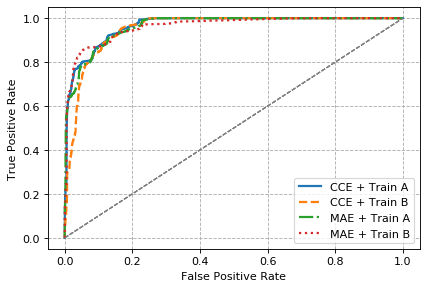

In [7]:
fprs, tprs, thresholds = dict(), dict(), dict()
linestyle_list = ['-', '--', '-.', ':']
cce_str = 'CCE '
mae_str = 'MAE '
legend_list = [cce_str + '+ Train A', cce_str + '+ Train B', mae_str + '+ Train A', mae_str + '+ Train B']
plt.figure(dpi=80)
for i, m in enumerate(model_list):
    fpr, tpr, threshold = metrics.roc_curve(y_test, l1_norms[m], drop_intermediate=False)
    fprs[m], tprs[m], thresholds[m] = fpr, tpr, threshold
    plt.plot(fpr, tpr, linestyle=linestyle_list[i], lw=2)
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='_nolegend_')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(linestyle='--')
    plt.legend(legend_list, loc='lower right')

### AUC(Area Under Curve)

In [8]:
auc_list = list()
for m in model_list:
    auc_list.append(metrics.auc(fprs[m], tprs[m]))
df = pd.DataFrame({'AUC': auc_list})
df.index = legend_list
df = df.round(3)
df.head()

,AUC
CCE + Train A,0.966
CCE + Train B,0.954
MAE + Train A,0.964
MAE + Train B,0.962


## Performance table

### Performance table calculation

In [9]:
df_dict = dict()
for m in model_list:
    fpr_, tpr_, thr_ = fprs[m], tprs[m], thresholds[m]
    tpr, fpr, acc, rec, pre, spe, f1, thr = [list() for i in range(8)]
    for r in range(90, 100):
        r *= 0.01        
        tpr.append(tpr_[np.where(tpr_ >= r)[0][0]])
        fpr.append(fpr_[np.where(tpr_ >= r)[0][0]])
        acc.append((tpr[-1] * atk + (1 - fpr[-1]) * nrm) / (atk + nrm))
        rec.append(tpr[-1])
        pre.append(tpr[-1] * atk / (tpr[-1] * atk + fpr[-1] * nrm))
        spe.append(1 - fpr[-1])
        f1.append(2 * rec[-1] * pre[-1] / (rec[-1] + pre[-1]))
        thr.append(thr_[np.where(tpr_ >= r)[0][0]])
    df = pd.DataFrame({
        'TPR' : tpr, 'FPR': fpr, 'Threshold': thr, 'Accuracy': acc,
        'Specifity': spe, 'Precision': pre, 'Recall': rec, 'F1-score': f1
    })
    df = df.round(3)
    df_dict[m] = df.copy()
    df.to_csv(os.path.join('perf', m[:-3] + '.csv'), index=False)

### Data frame settings

In [10]:
subset = ['Accuracy', 'F1-score']

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

### Performance table of categorical cross entropy + Train A

In [11]:
df_dict[model_list[0]].style.hide_index().apply(highlight_max, subset=subset).format('{:.3f}')

TPR,FPR,Threshold,Accuracy,Specifity,Precision,Recall,F1-score
0.900,0.124,1.862,0.890,0.876,0.906,0.900,0.903
0.910,0.126,1.835,0.895,0.874,0.905,0.910,0.908
0.920,0.129,1.795,0.899,0.871,0.904,0.920,0.912
0.930,0.152,1.532,0.895,0.848,0.890,0.930,0.910
0.940,0.162,1.366,0.896,0.838,0.885,0.940,0.912
0.950,0.171,1.242,0.898,0.829,0.880,0.950,0.914
0.960,0.189,1.067,0.896,0.811,0.871,0.960,0.913
0.971,0.209,0.941,0.894,0.791,0.860,0.971,0.912
0.980,0.218,0.893,0.895,0.782,0.856,0.980,0.914
0.992,0.220,0.882,0.900,0.780,0.856,0.992,0.919


### Performance table of categorical cross entropy + Train B

In [12]:
df_dict[model_list[1]].style.hide_index().apply(highlight_max, subset=subset).format('{:.3f}')

TPR,FPR,Threshold,Accuracy,Specifity,Precision,Recall,F1-score
0.900,0.129,1.455,0.888,0.871,0.902,0.900,0.901
0.910,0.136,1.335,0.890,0.864,0.898,0.910,0.904
0.920,0.152,1.073,0.889,0.848,0.889,0.920,0.904
0.930,0.158,1.000,0.892,0.842,0.886,0.930,0.908
0.940,0.162,0.984,0.896,0.838,0.885,0.940,0.912
0.950,0.166,0.973,0.900,0.834,0.883,0.950,0.916
0.960,0.176,0.944,0.901,0.824,0.878,0.960,0.917
0.970,0.206,0.769,0.894,0.794,0.862,0.970,0.913
0.980,0.229,0.658,0.890,0.771,0.850,0.980,0.910
0.991,0.236,0.621,0.893,0.764,0.847,0.991,0.914


### Performance table of mean absolute error + Train A

In [13]:
df_dict[model_list[2]].style.hide_index().apply(highlight_max, subset=subset).format('{:.3f}')

TPR,FPR,Threshold,Accuracy,Specifity,Precision,Recall,F1-score
0.900,0.127,1.560,0.888,0.873,0.903,0.900,0.902
0.910,0.130,1.520,0.893,0.870,0.902,0.910,0.906
0.920,0.143,1.380,0.893,0.857,0.895,0.920,0.907
0.930,0.160,1.290,0.891,0.840,0.885,0.930,0.907
0.940,0.178,1.193,0.889,0.822,0.874,0.940,0.906
0.950,0.190,1.109,0.890,0.810,0.869,0.950,0.908
0.960,0.210,0.823,0.887,0.790,0.858,0.960,0.906
0.970,0.226,0.658,0.886,0.774,0.850,0.970,0.906
0.981,0.228,0.639,0.891,0.772,0.850,0.981,0.911
0.990,0.230,0.624,0.895,0.770,0.851,0.990,0.915


### Performance table of mean absolute error + Train B

In [14]:
df_dict[model_list[3]].style.hide_index().apply(highlight_max, subset=subset).format('{:.3f}')

TPR,FPR,Threshold,Accuracy,Specifity,Precision,Recall,F1-score
0.900,0.138,1.180,0.884,0.862,0.896,0.900,0.898
0.910,0.140,1.169,0.888,0.860,0.895,0.910,0.903
0.920,0.145,1.138,0.892,0.855,0.893,0.920,0.906
0.930,0.156,1.066,0.893,0.844,0.888,0.930,0.908
0.940,0.184,0.712,0.887,0.816,0.871,0.940,0.904
0.950,0.217,0.435,0.878,0.783,0.853,0.950,0.899
0.960,0.226,0.397,0.880,0.774,0.849,0.960,0.901
0.970,0.230,0.389,0.884,0.770,0.848,0.970,0.905
0.980,0.322,0.249,0.850,0.678,0.801,0.980,0.882
0.990,0.471,0.150,0.791,0.529,0.735,0.990,0.844


## Analyze precision and recall of up to top 50% reconstruction error

### Analyze only the first model

In [15]:
m = model_list[0]
recons_err = np.copy(l1_norms[m])
label = np.copy(y_test)

### Sort with non-ascending order

In [16]:
idx = np.argsort(recons_err)[::-1]
recons_err = recons_err[idx]
label = label[idx]

### List of top rate

In [17]:
rate = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

### Analyze

In [18]:
pre, rec, thr = list(), list(), list()
for r in rate:
    last = int(r * len(recons_err))
    recons_err_ = recons_err[:last]
    label_ = label[:last]
    tn, fp, fn, tp = metrics.confusion_matrix(label_, [1]*len(label_), labels=[0, 1]).ravel()
    pre.append(tp / (tp + fp))
    rec.append(tp / (tp + tn))
    thr.append(recons_err_[last-1])

### Show top analyze table

In [19]:
df = pd.DataFrame({
    'Top rate': [100 * r for r in rate], 'Threshold': thr,
    'Precision': pre, 'Recall': rec
})
df = df.round(3)
df.style.hide_index().format('{:.3f}').format('{}%', subset='Top rate')

Top rate,Threshold,Precision,Recall
0.1%,9.798,1.000,1.000
1.0%,9.414,0.996,1.000
5.0%,9.069,0.999,1.000
10.0%,7.316,0.995,1.000
15.0%,6.290,0.986,1.000
20.0%,6.008,0.989,1.000
25.0%,5.905,0.991,1.000
30.0%,5.771,0.991,1.000
35.0%,5.563,0.989,1.000
40.0%,5.056,0.979,1.000
